# Bivariate Analysis

**Purpose:** Analyze relationships between pairs of variables to understand how features relate to each other and to target variables.

**Steps:**
1. Numerical features vs target variables
2. Categorical features vs target variables
3. Feature-to-feature relationships (correlation)

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)

## Load Database

In [ ]:
# Connect to database and load full dataset
conn = sqlite3.connect('../databases/nhanes_1st.db')
df = pd.read_sql_query('SELECT * FROM raw_dataset', conn)
conn.close()
print(f"Dataset shape: {df.shape}")

Dataset shape: (56893, 29)


1. NUMERICAL FEATURES VS TARGET VARIABLES

Comparing 6 key features with Cardiovascular Disease:


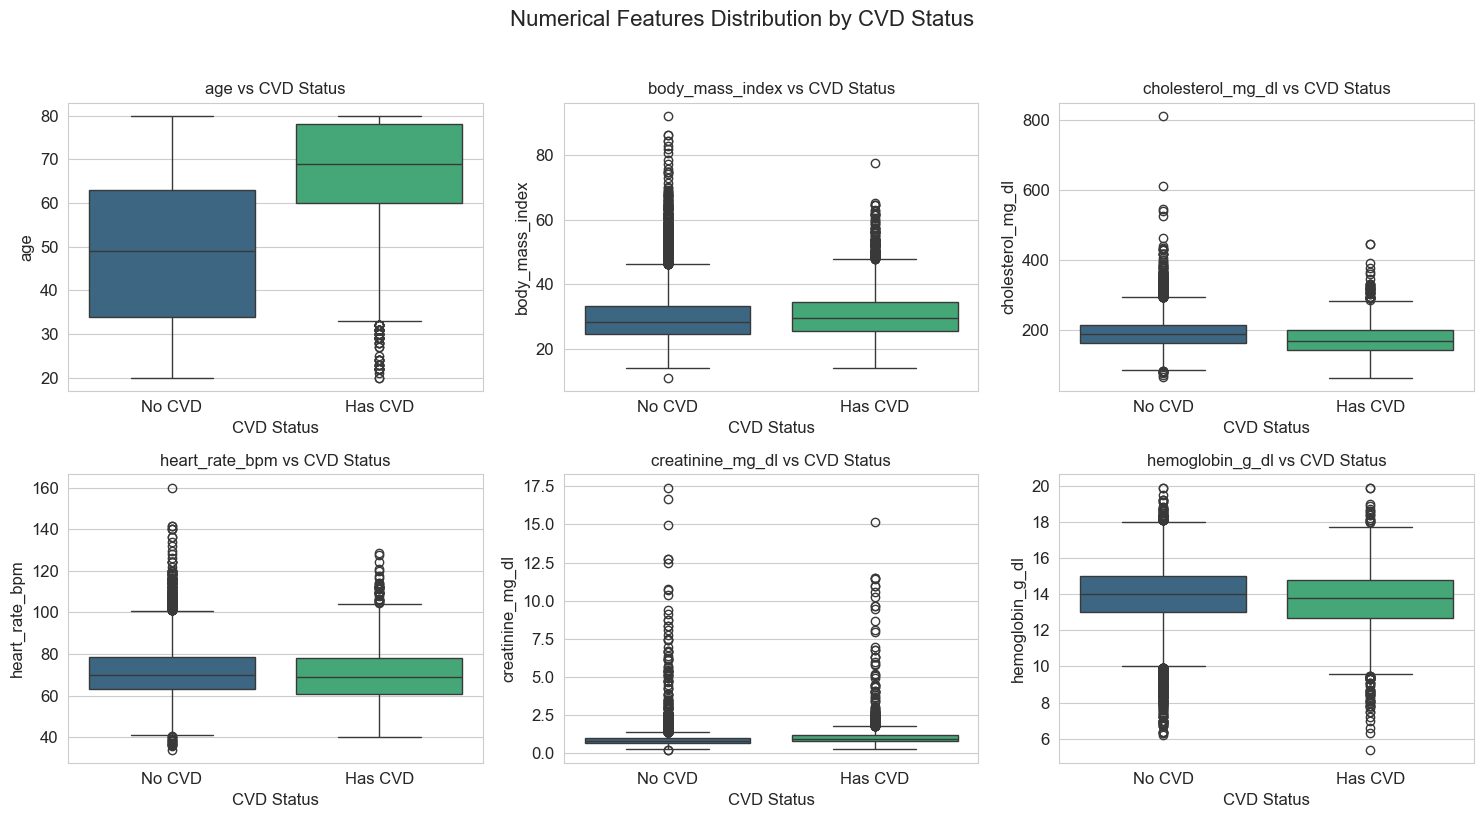

In [ ]:
# =========================================================
# 1. NUMERICAL FEATURES VS TARGET VARIABLES
# =========================================================

print("="*80)
print("1. NUMERICAL FEATURES VS TARGET VARIABLES")
print("="*80)

# Key numerical features to compare with CVD
key_features = ['age', 'body_mass_index', 'cholesterol_mg_dl', 'heart_rate_bpm', 
                'creatinine_mg_dl', 'hemoglobin_g_dl']

print(f"\nComparing {len(key_features)} key features with Cardiovascular Disease:")

# Boxplots: Numerical features vs CVD status
n_cols = 3
n_rows = int(np.ceil(len(key_features) / n_cols))
plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(key_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='has_cardiovascular_disease', y=col, data=df, 
                palette='viridis', hue='has_cardiovascular_disease', legend=False)
    plt.title(f'{col} vs CVD Status', fontsize=12)
    plt.xlabel('CVD Status')
    plt.ylabel(col)
    plt.xticks([0, 1], ['No CVD', 'Has CVD'])

plt.suptitle('Numerical Features Distribution by CVD Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


2. CATEGORICAL FEATURES VS TARGET VARIABLES

GENDER vs Cardiovascular Disease:
         cvd_rate  count
gender                  
1.0     14.208867  16173
2.0      9.936398  17924


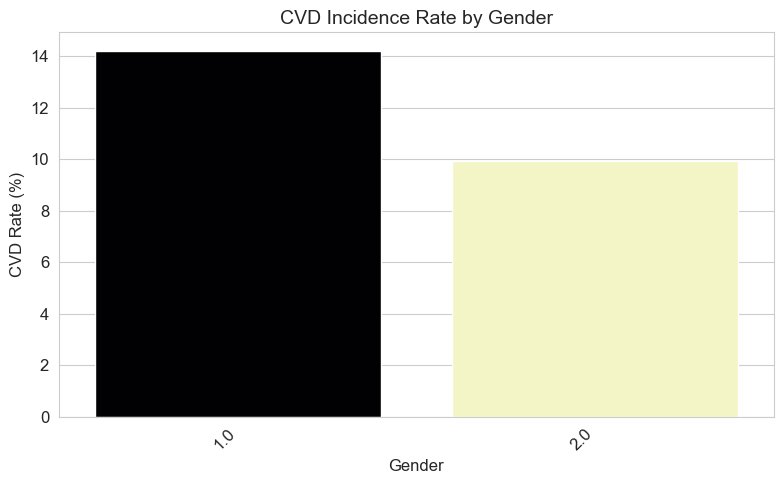


ETHNICITY vs Cardiovascular Disease:
            cvd_rate  count
ethnicity                  
3.0        15.133172  14042
7.0        13.441195   1607
4.0        12.221131   7127
2.0        10.051253   3512
1.0         7.196877   4099
6.0         5.902965   3710


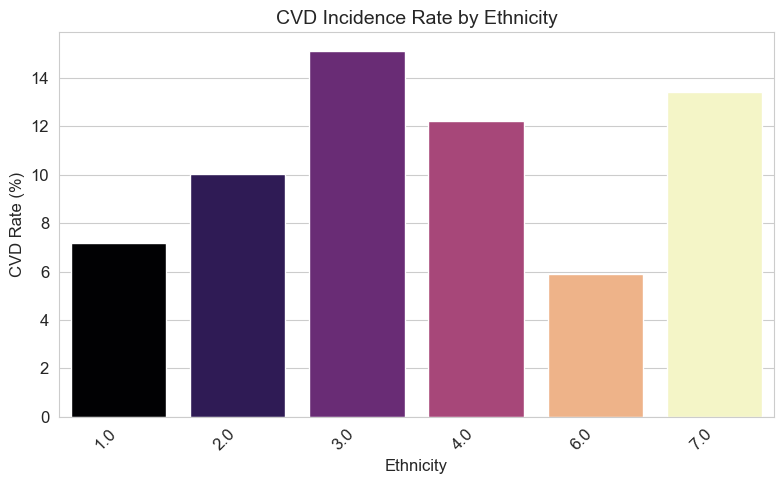


SMOKING_STATUS vs Cardiovascular Disease:
                 cvd_rate  count
smoking_status                  
3.0             19.752036   8227
1.0             14.353968   4814
2.0              9.884170   1295


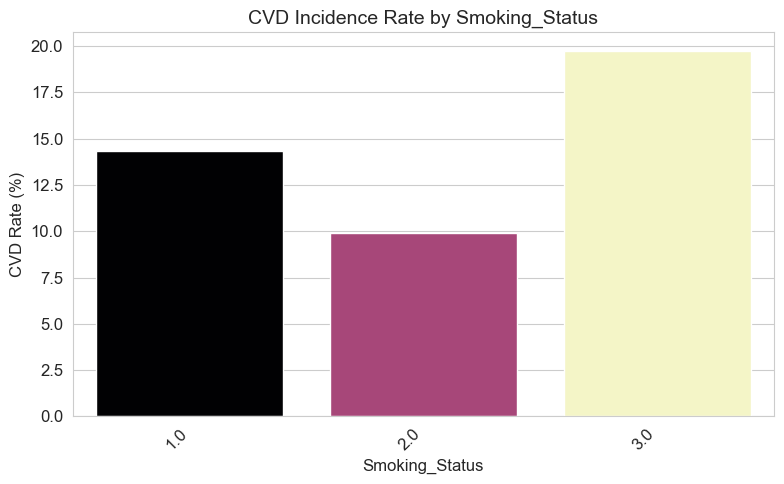

In [ ]:
# =========================================================
# 2. CATEGORICAL FEATURES VS TARGET VARIABLES
# =========================================================

print("\n" + "="*80)
print("2. CATEGORICAL FEATURES VS TARGET VARIABLES")
print("="*80)

# Analyze categorical features impact on CVD
categorical_features = ['gender', 'ethnicity', 'smoking_status']

for cat_feature in categorical_features:
    if cat_feature in df.columns:
        print(f"\n{cat_feature.upper()} vs Cardiovascular Disease:")
        
        # Calculate CVD rate by category
        cvd_by_category = df.groupby(cat_feature)['has_cardiovascular_disease'].agg(['mean', 'count'])
        cvd_by_category['cvd_rate'] = cvd_by_category['mean'] * 100
        cvd_by_category = cvd_by_category.sort_values('cvd_rate', ascending=False)
        
        print(cvd_by_category[['cvd_rate', 'count']].to_string())
        
        # Visualize
        plt.figure(figsize=(8, 5))
        sns.barplot(x=cvd_by_category.index, y=cvd_by_category['cvd_rate'], 
                   palette='magma', hue=cvd_by_category.index, legend=False)
        plt.title(f'CVD Incidence Rate by {cat_feature.title()}', fontsize=14)
        plt.ylabel('CVD Rate (%)')
        plt.xlabel(cat_feature.title())
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


3. FEATURE CORRELATION ANALYSIS

Correlation matrix for 8 key features:


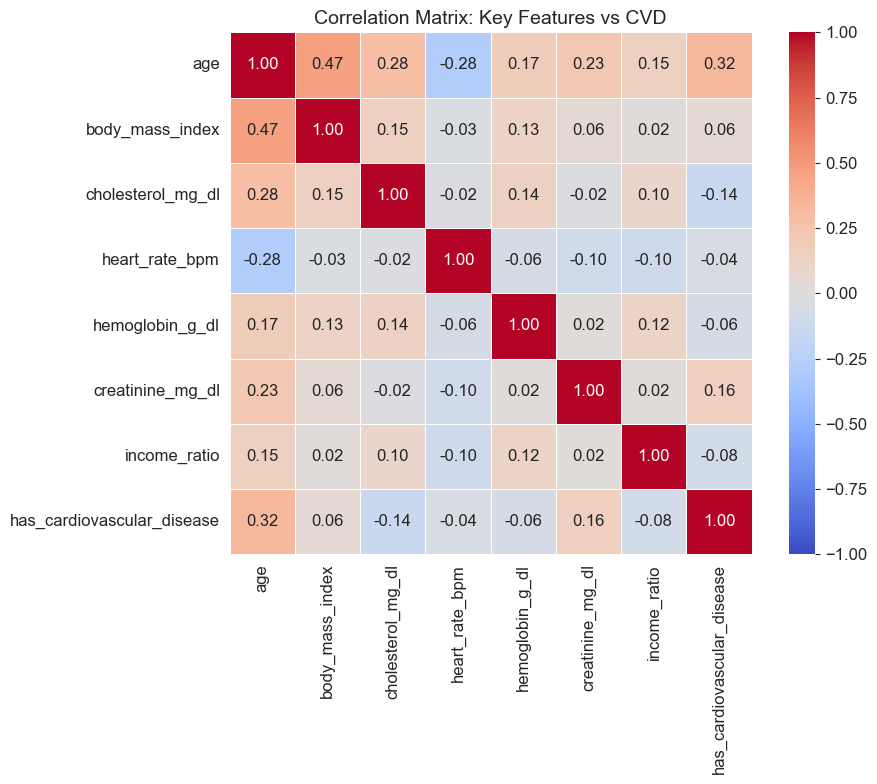


Top correlations with Cardiovascular Disease:
age                  0.322301
creatinine_mg_dl     0.158126
cholesterol_mg_dl    0.136795
income_ratio         0.079257
hemoglobin_g_dl      0.062457
body_mass_index      0.058773
heart_rate_bpm       0.040028


In [ ]:
# =========================================================
# 3. FEATURE-TO-FEATURE RELATIONSHIPS (CORRELATION)
# =========================================================

print("\n" + "="*80)
print("3. FEATURE CORRELATION ANALYSIS")
print("="*80)

# Select key numerical features for correlation analysis
corr_features = [
    'age', 'body_mass_index', 'cholesterol_mg_dl', 'heart_rate_bpm', 
    'hemoglobin_g_dl', 'creatinine_mg_dl', 'income_ratio', 'has_cardiovascular_disease'
]

print(f"\nCorrelation matrix for {len(corr_features)} key features:")

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
           linewidths=0.5, square=True, center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key Features vs CVD', fontsize=14)
plt.tight_layout()
plt.show()

# Find top correlations with CVD
print("\nTop correlations with Cardiovascular Disease:")
cvd_corr = corr_matrix['has_cardiovascular_disease'].abs().sort_values(ascending=False)
cvd_corr = cvd_corr[cvd_corr.index != 'has_cardiovascular_disease']  # Remove self
print(cvd_corr.head(10).to_string())
